In [1]:
# pip install langchain_openai

In [2]:
from typing import Annotated
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"


In [5]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F0D6536710>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F0D65646D0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [7]:
@tool
def add(a: float, b: float):
    """Add two numbers"""
    return a+b

tools = [add]
llm_with_tool = llm.bind_tools(tools)

In [8]:
def call_llm_model(state: State) -> State:
    return {"messages": [llm_with_tool.invoke(state['messages'])]}

In [ ]:
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
# builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph=builder.compile()

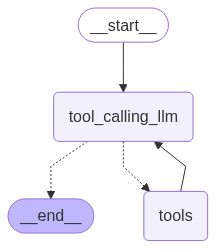

In [10]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response = graph.invoke({"messages": "What is 7 plus 7"})
response

In [15]:
from langchain_core.messages import HumanMessage

# Provide input as a list of BaseMessage (here, HumanMessage)
response = graph.invoke({
    "messages": [HumanMessage(content="Hi")]
})
response

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'greet' which was not request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "greet"\n      },\n      "parameters": {}\n    }\n  ]\n}\n</tool-use>'}}